<a href="https://colab.research.google.com/github/ekourkchi/Weather_research/blob/master/WeatherNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import pandas as pd
from datetime import datetime
import time

In [2]:
data = pd.read_excel('/content/drive/My Drive/50136-Mohe.xlsx')

for col in data.columns:
  newcol = col.split("(")[0]
  data.rename(columns={col:newcol}, inplace=True)

data.set_index("TIMESTAMP", inplace=True)

data = data.resample('1d').mean()

data = data.interpolate(method='linear', limit_direction='forward', axis=0)

data["MA"] = data["ET0"].rolling('7d').mean()

data["MAD"] = data["ET0"] - data["MA"]
data["STD"] = np.sqrt(data["MAD"].rolling('7d').std())


data["ET1"] = data.shift(+1, freq='d')["ET0"]
data["delta"] = data["ET0"] - data["ET1"]

data["ET0"] = data["ET0"].ffill()
data = data.dropna()

data.head(10)

,DOY,T,VPD,gamma,Delta,U,Rn,ET0,MA,MAD,STD,ET1,delta
TIMESTAMP,,,,,,,,,,,,,
1990-01-02,2.0,-33.2,0.006802,0.067381,4.935265,0.0,3.149681,1.267761,1.252329,0.015432,0.104462,1.236897,0.030865
1990-01-03,3.0,-33.5,0.005730,0.067381,4.941713,0.0,3.172246,1.276866,1.260508,0.016358,0.095858,1.267761,0.009105
1990-01-04,4.0,-31.8,0.002196,0.067381,4.905367,0.0,1.194855,0.480895,1.065605,-0.584710,0.545663,1.276866,-0.795971
1990-01-05,5.0,-22.9,0.026560,0.067381,4.722477,1.8,3.223596,1.288056,1.110095,0.177961,0.542296,0.480895,0.807161
1990-01-06,6.0,-27.9,0.011176,0.067381,4.823721,0.3,3.154401,1.267654,1.136355,0.131299,0.525538,1.288056,-0.020402
1990-01-07,7.0,-27.8,0.011750,0.067381,4.821659,0.0,1.299238,0.522783,1.048702,-0.525918,0.558383,1.267654,-0.744871
1990-01-08,8.0,-22.6,0.019174,0.067381,4.716522,0.0,3.049993,1.226870,1.047269,0.179600,0.573801,0.522783,0.704086
1990-01-09,9.0,-34.0,0.004006,0.067381,4.952493,0.0,3.376555,1.359143,1.060324,0.298819,0.599647,1.226870,0.132273
1990-01-10,10.0,-33.9,0.004344,0.067381,4.950333,0.0,2.046567,0.823787,0.995598,-0.171812,0.601132,1.359143,-0.535356


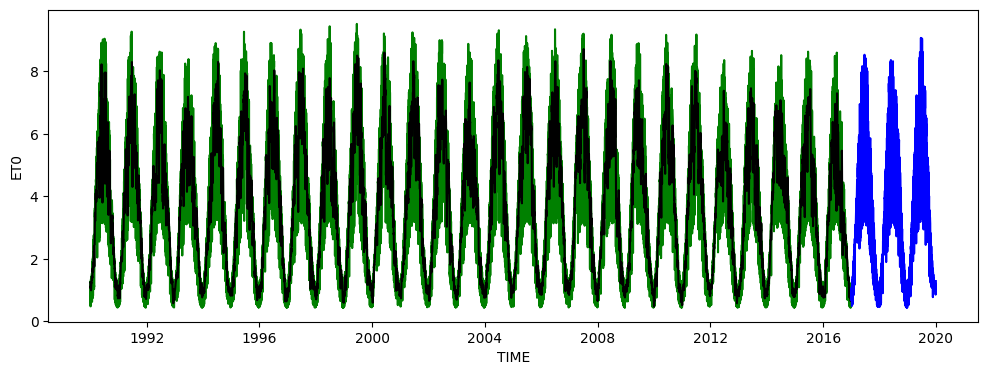

In [262]:
fig = py.figure(figsize=(10, 4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

subData = data.loc[:"2016-12-31"]
N = len(subData)
x = subData.index
y = subData["ET0"]
d = subData["delta"]
m = subData["MA"]
s = subData["STD"]
ax.plot(x, y, color='green')
ax.plot(x, subData["MA"], color='k')

ax.set_xlabel("TIME")
ax.set_ylabel("ET0")


subData_cross = data.loc["2017-01-01":]
N_cross = len(subData_cross)
x_cross = subData_cross.index
y_cross = subData_cross["ET0"]
d_cross = subData_cross["delta"]
m_cross = subData_cross["MA"]
s_cross = subData_cross["STD"]
ax.plot(x_cross, y_cross, color='blue')

# subData_test = data.loc["2019":]
# N_test = len(subData_test)
# x_test = subData_test.index
# y_test = subData_test["ET0"]
# ax.plot(x_test, y_test, color='black')




nDelay = 7

N = len(y)
XS = np.zeros((N-nDelay, 3*nDelay+1))
ys = np.zeros(N-nDelay)
for i in range(0, N-nDelay):
  XS[i,:nDelay] =  y[i:i+nDelay]
  XS[i,nDelay:nDelay*2] =  s[i:i+nDelay]    # y[i:i+nDelay]**2
  XS[i,2*nDelay:3*nDelay] =  m[i:i+nDelay]  # -y[i:i+nDelay]
  XS[i, 3*nDelay] = np.mean(XS[i,:nDelay])
  ys[i] = y[i+nDelay]


N_cross = len(y_cross)
XS_cross = np.zeros((N_cross-nDelay, 3*nDelay+1))
ys_cross = np.zeros(N_cross-nDelay)
for i in range(0, N_cross-nDelay):
  XS_cross[i,:nDelay] =  y_cross[i:i+nDelay]
  XS_cross[i,nDelay:nDelay*2] =  s_cross[i:i+nDelay]   # y_cross[i:i+nDelay]**2
  XS_cross[i,2*nDelay:3*nDelay] =  m_cross[i:i+nDelay] # -y_cross[i:i+nDelay]
  XS_cross[i, 3*nDelay] = np.mean(XS_cross[i,:nDelay])
  ys_cross[i] = y_cross[i+nDelay]



In [263]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Concatenate
import matplotlib.pyplot as plt


def myNN():


    model = tf.keras.models.Sequential()

    # model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(16, activation='relu'))

    # for i in range(20):
    #     model.add(tf.keras.layers.Dense(1, activation='relu'))



    # model.add(tf.keras.layers.Dense(2, activation='relu'))
    # model.add(tf.keras.layers.Dropout(0.25, seed=5))      

    # model.add(tf.keras.layers.Dense(4, activation='relu'))
    # model.add(tf.keras.layers.Dense(60, activation='relu'))
    # model.add(tf.keras.layers.Dense(60, activation='relu'))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    # model.add(tf.keras.layers.Dense(16, activation='relu'))
    # model.add(tf.keras.layers.Dense(16, activation='relu'))
    # model.add(tf.keras.layers.Dense(50, activation='relu'))
    # model.add(tf.keras.layers.Dense(8, activation='relu'))
    # model.add(tf.keras.layers.Dense(4, activation='relu'))
    # model.add(tf.keras.layers.Dropout(0.25, seed=5))
 
    # output layer
    model.add(tf.keras.layers.Dense(1, name='fc_out'))

    return model

In [264]:
nn_model = myNN()
nn_model.compile(loss='mse', optimizer='adam', metrics=['mae'])

for i in range(10000):
  n_epochs = 1
  nn_model_history = nn_model.fit(XS, ys, 
                                    epochs=n_epochs, batch_size = 2048, 
                                    verbose=1, shuffle=False)

  XS[:, 3*nDelay-1] = nn_model.predict(XS).reshape(-1)

Streaming output truncated to the last 5000 lines.
5/5 [==============================] - 0s 2ms/step - loss: 1.2487 - mae: 0.8273


In [266]:
nn_model.summary()

Model: "sequential_628"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2048 (Dense)           (None, 16)                368       
_________________________________________________________________
dense_2049 (Dense)           (None, 16)                272       
_________________________________________________________________
fc_out (Dense)               (None, 1)                 17        
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________


In [267]:
def plot_model_history(history):
    '''Plot the training and validation history for a TensorFlow network'''

    # Extract loss and accuracy
    loss = history.history['mse']
    val_loss = history.history['val_mse']
    acc = history.history['mae']
    val_acc = history.history['val_mae']
    
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
    ax[0].plot(np.arange(n_epochs), loss, label='Training')
    ax[0].plot(np.arange(n_epochs), val_loss, label='Validation')
    ax[0].set_title('Mean Square Error')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(np.arange(n_epochs), acc, label='Training')
    ax[1].plot(np.arange(n_epochs), val_acc, label='Validation')
    ax[1].set_title('Mean Absolute Error Curves')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean Absolute Error')
    
# plot the training history
# for key in vgg_model.history.history:
#   print key

plot_model_history(nn_model.history)

KeyError: ignored

In [268]:
for key in nn_model.history.history:
  print(key)

In [269]:
ys_cros_pred = nn_model.predict(XS_cross)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

RMSE = mean_squared_error(ys_cross, ys_cros_pred, squared=False)
R2 = r2_score(ys_cross, ys_cros_pred)

print(RMSE, R2)

1.1031304186506323 0.7335963046685561


In [270]:
XS.shape

(9854, 22)

In [272]:
e = []
ep = []
for jj in range(100):

    # nn_model = myNN()
    # nn_model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])
    nn_model.fit(XS_cross[jj,:].reshape(1,nDelay*3+1), ys_cross[jj].reshape(-1), epochs=1, verbose=0, batch_size = 1, shuffle=False)

    e.append(ys_cross[jj+1])
    pred = nn_model.predict(XS_cross[jj+1,:].reshape(1,nDelay*3+1))
    ep.append(pred[0][0])
    print(jj+1, ys_cross[jj+1], pred)


1 0.5712688132294267 [[0.835115]]
2 1.15003037366711 [[0.82317317]]
3 1.228484730529164 [[0.92971444]]
4 0.9574617910919239 [[1.0488404]]
5 0.5380758133542277 [[0.96754277]]
6 1.320327429457517 [[0.8905843]]
7 1.237640154420721 [[1.0357935]]
8 1.438902030454272 [[1.168768]]
9 1.429003494105666 [[1.1687384]]
10 1.390666283977021 [[1.2326045]]
11 0.5891216350763456 [[1.25931]]
12 1.322947649635729 [[1.1923716]]
13 1.552073392902199 [[1.2362818]]
14 1.633278135084661 [[1.3445374]]
15 1.608190411694397 [[1.4521346]]
16 1.662914557409515 [[1.5113553]]
17 1.437634605736622 [[1.6033481]]
18 1.043270259787652 [[1.5943644]]
19 1.851596213080347 [[1.5151188]]
20 1.887919244792413 [[1.6962212]]
21 1.937125247943632 [[1.8291707]]
22 1.5739512244969798 [[1.9791713]]
23 1.2107772010503277 [[1.9266413]]
24 0.8476031776036753 [[1.7926602]]
25 2.092949963455783 [[1.584212]]
26 1.248626609802337 [[1.7540275]]
27 2.122159267581528 [[1.5517023]]
28 2.165168016686452 [[1.6932595]]
29 2.287458785814069 [[1.

In [273]:
RMSE = mean_squared_error(e, ep, squared=False)
R2 = r2_score(e, ep)

print(RMSE, R2)


0.9014300450763901 0.5961844204424015
